# Simulated annealing

## Cost function

In [381]:
def E_sum(s, W):
    sum = 0
    N = len(s)
    for i in np.arange(N):
        for j in np.arange(N):
            sum += W[i, j] * s[i] * s[j]
    return -0.5 * sum

In [382]:
# Vectorized form of cost function on sheet
def E(s, W):
    return -0.5 * s @ W @ s.T

Confirm that vectorized version is correct:

In [383]:
np.allclose(E_sum(s, W), E(s, W))

True

Cost function for single node:

In [384]:
def E_si_sum(s, i, W):
    sum = 0
    N = len(s)
    for j in np.arange(N):
        sum += W[i, j] * s[i] * s[j]
    return -0.5 * sum

In [385]:
def E_si(s, i, W):
    return -0.5 * s[i] * (W[i] @ s)

Confirm that vectorized version is correct:

In [386]:
np.allclose(E_si_sum(s, 2, W), E_si(s, 2, W))

True

In [387]:
def P_switch(delta_E, beta):
    return 1 / (1 + np.exp(beta * delta_E))

print("For small delta_E high probability to switch:")
print(P_switch(-0.2, 1.05))
print(P_switch(-0.2, 20))

print()

print("For large delta_E low probability to switch:")
print(P_switch(0.5, 1.05))
print(P_switch(0.5, 20))

For small delta_E high probability to switch:
0.5523079095743253
0.9820137900379085

For large delta_E low probability to switch:
0.37168381170463377
4.5397868702434395e-05


## Initialization of s and W

In [388]:
import numpy as np

def initialize_nodes_rand(N):
    s = np.random.choice([-1, 1], N)
    return s

s = initialize_nodes_rand(N)
s

array([-1, -1, -1, -1, -1,  1])

In [389]:
def initialize_weights_rand(N):
    W = np.random.uniform(-1, 1, (N, N))
    # make W symmetric
    W = (W + W.T) / 2
    np.fill_diagonal(W, 0)
    return W

W = initialize_weights_rand(N)
W

array([[ 0.        ,  0.1335827 ,  0.02690122,  0.31395541,  0.17142208,
        -0.57350028],
       [ 0.1335827 ,  0.        , -0.46887784,  0.05324696,  0.18733603,
         0.46106917],
       [ 0.02690122, -0.46887784,  0.        ,  0.77820739,  0.45022296,
        -0.54951613],
       [ 0.31395541,  0.05324696,  0.77820739,  0.        ,  0.12082692,
         0.29785174],
       [ 0.17142208,  0.18733603,  0.45022296,  0.12082692,  0.        ,
         0.1915702 ],
       [-0.57350028,  0.46106917, -0.54951613,  0.29785174,  0.1915702 ,
         0.        ]])

In [390]:
W = initialize_weights_rand(N)

## Optimization

In [391]:
beta0 = 1.01
tau = 1.02
t_max = 150
M_small = 1
M_large = 20

In [392]:
s = initialize_nodes_rand(N)

print("s:", s)
print("W:", W)

s: [-1 -1 -1 -1 -1 -1]
W: [[ 0.         -0.62182073  0.07142142 -0.00429681 -0.34242211  0.33390618]
 [-0.62182073  0.         -0.41177879  0.15707106  0.07052448 -0.2453142 ]
 [ 0.07142142 -0.41177879  0.          0.09853543  0.42473812  0.10990625]
 [-0.00429681  0.15707106  0.09853543  0.         -0.7011961   0.1159225 ]
 [-0.34242211  0.07052448  0.42473812 -0.7011961   0.         -0.14961432]
 [ 0.33390618 -0.2453142   0.10990625  0.1159225  -0.14961432  0.        ]]


In [393]:
def optimize(s, M):
    s = s.copy()
    beta = beta0
    N = len(s)
    temps = []
    energies = []
    for t in np.arange(t_max):
        temps.append(1 / beta)
        energies.append(E(s=s, W=W))
        for m in np.arange(M):
            i = np.random.choice(N)
            delta_E = -2 * E_si(s=s, i=i, W=W)
            flip_prob = P_switch(delta_E=delta_E, beta=beta)
            if np.random.rand() < flip_prob:
                s[i] *= -1
        beta *= tau
    return s, temps, energies

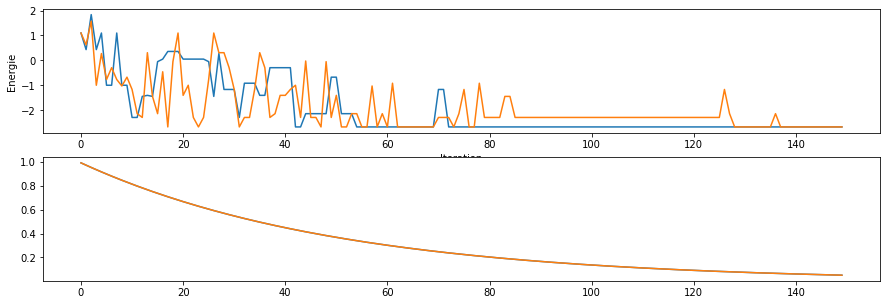

In [394]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(15, 5), nrows=2)
for M in [M_small, M_large]:
    s_optimized, temps, energies = optimize(s, M)
    ax = axes[0]
    ax.plot(np.arange(len(energies)), energies)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Energie")
    
    ax = axes[1]
    ax.plot(np.arange(len(temps)), temps)

## Visualize state energy value

In [395]:
def state_to_bullet_string(s):
    bullets = ["•" if node == 1 else "◦" for node in s]
    return "".join(bullets)

In [396]:
possible_states = np.array(
    [[-1 if n == "0" else 1 for n in list(format(i, 'b').zfill(N))] for i in np.arange(2**N)]
)

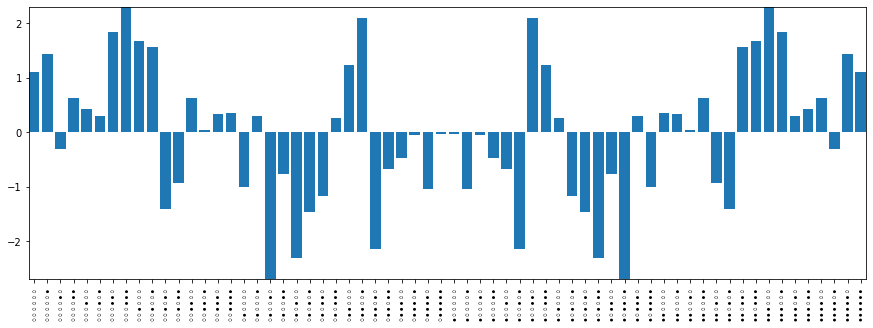

In [397]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.margins(0)

x = np.arange(2**6)
possible_states_energy = [E(s, W) for s in possible_states]

possible_states_labels = [state_to_bullet_string(s) for s in possible_states]

ax.bar(x, possible_states_energy)
ax.set_xticks(x)
ax.set_xticklabels(possible_states_labels)
ax.xaxis.set_tick_params(rotation=90)

## Plot probabilities for states

In [398]:
def Z(possible_states, beta, W=W):
    return sum([np.exp(-beta * E(s, W)) for s in possible_states])

def P(s, beta, Z, W=W):
    return (1/Z) * np.exp(-beta * E(s, W))

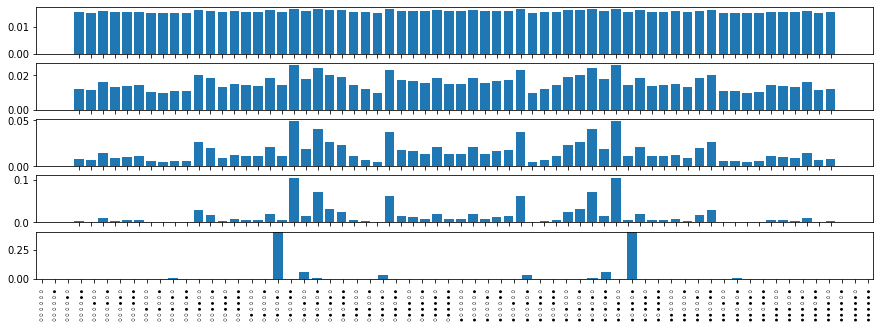

In [399]:
betas = [0.02, 0.2, 0.5, 1, 5]

fig, axes = plt.subplots(nrows=len(betas), figsize=(15, 5))
plt.margins(0)

def plot_probabilities_for_beta(ax, beta):
    x = np.arange(2**6)
    current_Z = Z(possible_states, beta, W)
    possible_states_probabilities = [P(s, beta, current_Z, W) for s in possible_states]

    possible_states_labels = [state_to_bullet_string(s) for s in possible_states]

    ax.bar(x, possible_states_probabilities)
    ax.set_xticks(x)
    ax.set_xticklabels(possible_states_labels)
    ax.xaxis.set_tick_params(rotation=90)
    
for i, beta in zip(np.arange(len(betas)), betas):
    plot_probabilities_for_beta(axes[i], beta)

# Mean-field annealing

In [412]:
beta0 = 1.05
tau = 1.05
t_max = 300
epsilon = 0.01

s = np.random.rand(6)
print("s:", s)

def optimize_by_mean_field(s, M):
    s = s.copy()
    beta = beta0
    temps = []
    energies = []
    e = np.full(N, np.inf)
    
    for t in np.arange(t_max):
        delta_e = math.inf
        temps.append(1 / beta)
        energies.append(E(s=s, W=W))

        while delta_e > epsilon:
            e_old = e.copy()
            for i in np.arange(N):
                e[i] = -sum([W[i, j] * s[j] for j in np.arange(N)])
                s[i] = np.tanh(-beta * e[i])
            delta_e = np.absolute(e - e_old).all()
        beta *= tau
    return s, temps, energies

s: [0.82167713 0.1303849  0.22091925 0.86820272 0.42941459 0.79781692]


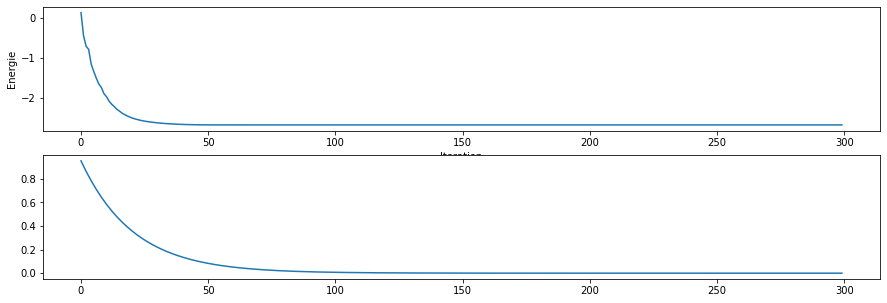

In [413]:
s_optimized, temps, energies = optimize_by_mean_field(s, M)

fig, axes = plt.subplots(figsize=(15, 5), nrows=2)

ax = axes[0]
ax.plot(np.arange(len(energies)), energies)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energie")

ax = axes[1]
ax.plot(np.arange(len(temps)), temps)